In [1]:
import numpy as np
import tensorflow as tf
import strawberryfields as sf
from numba import njit

In [2]:
sf.__version__

'0.17.0'

In [3]:
def test_sf(cutoff_dim):
    eng = sf.Engine('fock', backend_options={'cutoff_dim':cutoff_dim})

    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)

    
    prog = sf.Program(1)
    gamma1r = np.abs(gamma1)
    gamma1phi = np.angle(gamma1)

    with prog.context as mode:
        sf.ops.Dgate(gamma1r,phi=gamma1phi) | mode[0]
        sf.ops.Rgate(phi1) | mode[0]
        sf.ops.Sgate(zeta1) | mode[0]
    state_out = eng.run(prog).state.ket()
    
    return state_out

In [4]:
import numpy as np
from numba import jit

@njit  # (nb.types.Tuple((nb.complex128, nb.complex128[:], nb.complex128[:,:]))(nb.complex128, nb.float64, nb.complex128))
def C_mu_Sigma(gamma: np.complex, phi: np.float, z: np.complex) -> tuple:
    """
    Utility function to construct:
    1. C constant
    2. Mu vector
    3. Sigma matrix
    Arguments:
        gamma (complex): displacement parameter
        phi (float): phase rotation parameter
        z (complex): squeezing parameter
        dtype (numpy type): unused for now
    Returns:
        C (complex), mu (complex array[2]), Sigma (complex array[2,2])
    """
#     z = convert_scalar(z)
#     phi = convert_scalar(phi)
#     gamma = convert_scalar(gamma)
    r = np.abs(z)
    delta = np.angle(z)
    exp2phidelta = np.exp(1j * (2 * phi + delta))
    eiphi = np.exp(1j * phi)
    tanhr = np.tanh(r)
    coshr = np.cosh(r)
    cgamma = np.conj(gamma)

    C = np.exp(-0.5 * np.abs(gamma) ** 2 - 0.5 * cgamma ** 2 * exp2phidelta * tanhr) / np.sqrt(coshr)
    mu = np.array([cgamma * exp2phidelta * tanhr + gamma, -cgamma * eiphi / coshr,])
    Sigma = np.array([[exp2phidelta * tanhr, -eiphi / coshr], [-eiphi / coshr, -np.exp(-1j * delta) * tanhr],])

    return C, mu, Sigma


@njit
def R_matrix(gamma: np.complex, phi: np.float, z: np.complex, cutoff: int, old_state: np.array) -> np.array:
    """
    Directly constructs the transformed state recursively and exactly.

    Arguments:
        gamma (complex): displacement parameter
        phi (float): phase rotation parameter
        z (complex): squeezing parameter
        old_state (complex array[D]): State to be transformed

    Returns:
        R (complex array[D,D]): the matrix whose 1st column is the transformed state
    """

    dtype = old_state.dtype
    C, mu, Sigma = C_mu_Sigma(gamma, phi, z)

    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))

    R = np.zeros((cutoff, cutoff), dtype=dtype)
    G0 = np.zeros(cutoff, dtype=dtype)

    # first row of Transformation matrix
    G0[0] = C
    for n in range(1, cutoff):
        G0[n] = mu[1] / sqrt[n] * G0[n - 1] - Sigma[1, 1] * sqrt[n - 1] / sqrt[n] * G0[n - 2]

    # first row of R matrix
    for n in range(cutoff):
        R[0, n] = np.dot(G0[: cutoff - n], old_state)
        old_state = old_state[1:] * sqrt[1 : cutoff - n]

    # rest of R matrix
    for m in range(1, cutoff):
        for n in range(cutoff - m):
            R[m, n] = (
                mu[0] / sqrt[m] * R[m - 1, n]
                - Sigma[0, 0] * sqrt[m - 1] / sqrt[m] * R[m - 2, n]
                - Sigma[0, 1] / sqrt[m] * R[m - 1, n + 1]
            )

    return R

@jit(nopython=True)
def G_matrix(phiR, w, z, cutoff, dtype=np.complex128):
    """Calculates the Fock representation of the single-mode Gaussian gate parametrized
    as the product of the three gates R(phi)D(w)S(z).
    Args:
        phiR (float): angle of the phase rotation gate
        w (complex): displacement parameter
        z (complex): squeezing parameter
        cutoff (int): Fock ladder cutoff
        dtype (data type): Specifies the data type used for the calculation
    Returns:
        array[complex]: The Fock representation of the gate
    """

    rS = np.abs(z)
    phiS = np.angle(z)
    EZ = np.exp(1j*phiS)
    T = np.tanh(rS)
    S = 1/np.cosh(rS)
    ER = np.exp(1j*phiR)
    wc = np.conj(w)

    # 2nd derivatives of G
    R = np.array([
        [-T*EZ*ER**2, ER*S],
        [ER*S, T*np.conj(EZ)]
    ])

    # 1st derivatives of G
    y = np.array([ER*(w + T*EZ*wc), -wc*S])

    sqrt = np.sqrt(np.arange(cutoff))
    Z = np.zeros((cutoff, cutoff), dtype=dtype)

    Z[0, 0] = np.exp(-0.5*np.abs(w)**2 - 0.5*wc**2 * EZ * T)*np.sqrt(S)

    # rank 1
    for m in range(1, cutoff):
        Z[m, 0] = (y[0]/sqrt[m]*Z[m-1, 0] + R[0, 0]*sqrt[m-1]/sqrt[m]*Z[m-2, 0])

    # rank 2
    for m in range(cutoff):
        for n in range(1, cutoff):
            Z[m, n] = (y[1]/sqrt[n]*Z[m, n-1] + R[1, 1]*sqrt[n-1]/sqrt[n]*Z[m, n-2] + R[0, 1]*sqrt[m]/sqrt[n]*Z[m-1, n-1])

    return Z

In [5]:
def test_singlemode(cutoff_dim):
    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)

    Psi = np.zeros(cutoff_dim,dtype=np.complex128)
    Psi[0] = 1  #vaccum
    state_out = R_matrix(gamma1,phi1, zeta1,cutoff_dim, Psi)[:,0]
    return state_out

In [6]:
def test_singlemode2(cutoff_dim):
    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)

    Psi = np.zeros(cutoff_dim,dtype=np.complex128)
    Psi[0] = 1  #vaccum
    G = G_matrix(phi1, gamma1, zeta1, cutoff_dim)
    return tf.einsum("ab,b->a",G,Psi)

In [7]:
x = [5,10,15,20,25,30,35,40]

In [8]:
time_list_sf = []
for cutoff_dim in x:
    t = %timeit -o test_sf(cutoff_dim)
    time_list_sf.append(t.average)

675 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
753 µs ± 96.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.4 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
804 µs ± 149 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.05 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.23 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.17 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
981 µs ± 167 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
time_list_2mode = []
for cutoff_dim in x:
    t = %timeit -o test_singlemode(cutoff_dim)
    time_list_2mode.append(t.average)

43.3 µs ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.6 µs ± 3.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
56.4 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
55.9 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
42 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
52.4 µs ± 5.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
54.6 µs ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
59 µs ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
time_list_2mode2 = []
for cutoff_dim in x:
    t = %timeit -o test_singlemode2(cutoff_dim)
    time_list_2mode2.append(t.average)

The slowest run took 5.89 times longer than the fastest. This could mean that an intermediate result is being cached.
195 µs ± 168 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
174 µs ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
110 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
167 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
119 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
125 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
118 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
133 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
import seaborn as sns
sns.set_theme(style="ticks")

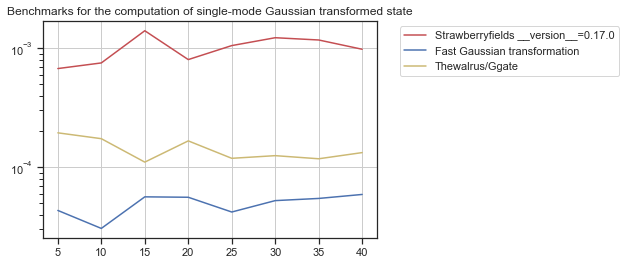

In [24]:
from matplotlib import pyplot as plt
plt1 = plt.plot(x,time_list_sf,'r');
plt2 = plt.plot(x,time_list_2mode,'b');
plt3 = plt.plot(x,time_list_2mode2,'y');
plt.yscale('log')
plt.grid(True)
plt.title("Benchmarks for the computation of single-mode Gaussian transformed state")
plt.legend((plt1[0],plt2[0],plt3[0]),("Strawberryfields __version__=0.17.0","Fast Gaussian transformation","Thewalrus/Ggate"), loc='upper left', bbox_to_anchor=(1.05, 1))

In [12]:
time_list_sf

[0.0006752872806308525,
 0.0007531335649962004,
 0.0014044097312892387,
 0.0008035298229827147,
 0.0010535703820060006,
 0.0012269991360039317,
 0.0011743098309878925,
 0.0009812628810094404]

In [13]:
time_list_2mode

[4.332443599456123e-05,
 3.0582840515333894e-05,
 5.635858594240355e-05,
 5.5904490800042235e-05,
 4.2014532799865785e-05,
 5.2391190157504753e-05,
 5.464335932795491e-05,
 5.9032425328457194e-05]

In [14]:
time_list_2mode2

[0.00019460400134058936,
 0.00017378074535767413,
 0.00011038235517168816,
 0.00016652150718561774,
 0.00011881984773125233,
 0.00012509981562865765,
 0.00011777446727002306,
 0.00013272617940175612]